## Estudo de critérios de transição de sigmoides para modelagem matemática de múltiplas ondas epidemiológicas

Testando diferentes filtros

Importando bibliotecas e módulos implementados

In [18]:
# External libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Implemented modules
import optimize
# Obs: modified version of the new_wave module
import new_wave_filt
from new_wave_filt import get_transition_points

Carregando dados

In [19]:
# Import data
data = pd.read_csv("../Datasets/osaka.csv") 
city_name = 'Osaka' 
indicator='cases'

In [20]:
if(indicator == 'deaths'):
    #deaths
    acc_data = data.cumulative_deceased
else:
    # cases
    #acc_data = data.total_confirmed
    acc_data = data.cumulative_confirmed #(Japan)

normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(0, len(acc_data)-1, len(acc_data))

normalized_acc_data = normalized_acc_data.tolist()

if(indicator == 'deaths'):
    daily_data = data.new_deceased
else:
    daily_data = data.new_confirmed


scaling_factor = 500
acc_data = acc_data / scaling_factor
daily_data = list(daily_data/ scaling_factor)

Definindo condições iniciais de cada sigmoide no modelo

In [21]:
# Initial Conditions

def initial_cond_0(y_t):
    #A0 = 100
    A0 = 2*max(y_t)
    tp0 = (2/3)*len(y_t)
    delta0 = (1/4)*len(y_t)
    nu0 = 1
    return [A0, tp0, delta0, nu0]

optimize.initial_cond = initial_cond_0

def update_cond_nw(A0, tp0):
    tp0 += 150 # Obs: ideal distance between sigmois ~ 150 days 
    A0 *= 0.005
    return [A0, tp0]
optimize.update_cond = update_cond_nw

## Testando diferentes filtros

In [22]:
# Moving average filter
def moving_average(x, win_size):
    filtered = np.convolve(x, np.ones(win_size), 'valid') / win_size
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

# Median filter
def median_filter(x, win_size):
    S = 1
    nrows = ((x.size-win_size)//S)+1
    n = x.strides[0]
    strided = np.lib.stride_tricks.as_strided(x, shape=(nrows,win_size), strides=(S*n,n))
    filtered  = np.median(strided,axis=1)
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

def butterworth_lowpass_filter(data, cutoff_freq, fs, order=2):
    #fs is the sampling rate
    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # lfilter apply filter along one dimension
    y = lfilter(b, a, data)
    return y

In [23]:
rel_rmse_by_test = {}
rel_rmse_by_test['Interval'] = ['Wave 1', 'Waves 1 to 2', 'Waves 1 to 3', 'Waves 1 to 4', 'Waves 1 to 5']

### 1 - Filtros padrão

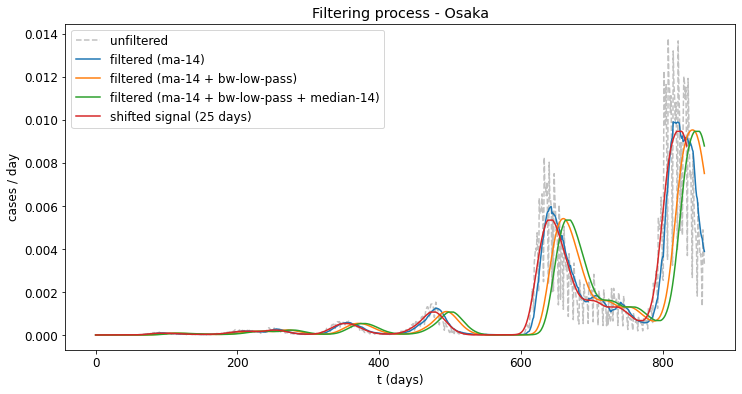

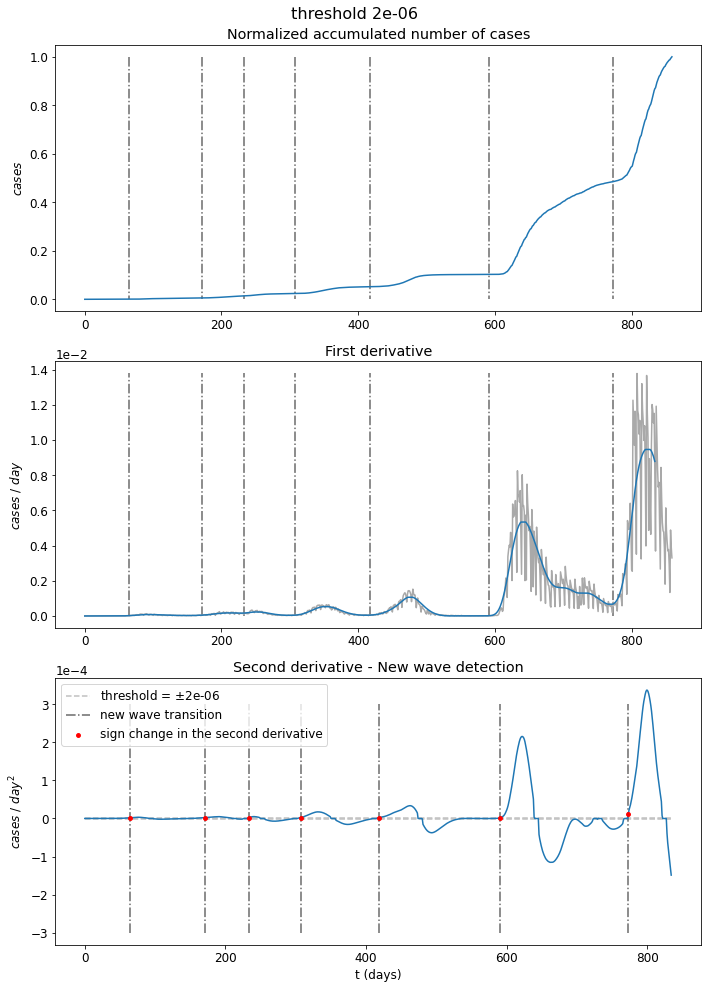

x_nw: [171, 233, 307, 418, 591]
Sigmoid #1 - A0:19.20972729900583 | tp0:99.56140716041266 | delta0:14.530072114851542 | nu0:1.0 
(optimal) Sigmoid #1 - A0:19.20972729900583 | tp0:99.56140716041266 | delta0:14.530072114851542 | nu0:1.0 
Sigmoid #2 - A0:37.707841369813735 | tp0:207.54118939391353 | delta0:12.053790129451295 | nu0:1.0 
(optimal) Sigmoid #2 - A0:37.707841369813735 | tp0:207.54118939391353 | delta0:12.053790129451295 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #3 - A0:24.570056184919295 | tp0:255.31708157069082 | delta0:7.14882028233732 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #3 - A0:24.570056184919295 | tp0:255.31708157069082 | delta0:7.14882028233732 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #4 - A0:109.36321871717348 | tp0:351.0208424251231 | delta0:11.32953288631205 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #4 - A0:109.36321871717348 | tp0:351.0208424251231 | delta0:11.32953288631205 | nu0:1.0 
Sigmoid #5 - A0:198.68600558687527 | tp0:471.88310887267966 | delta0:10.470113405155393 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))


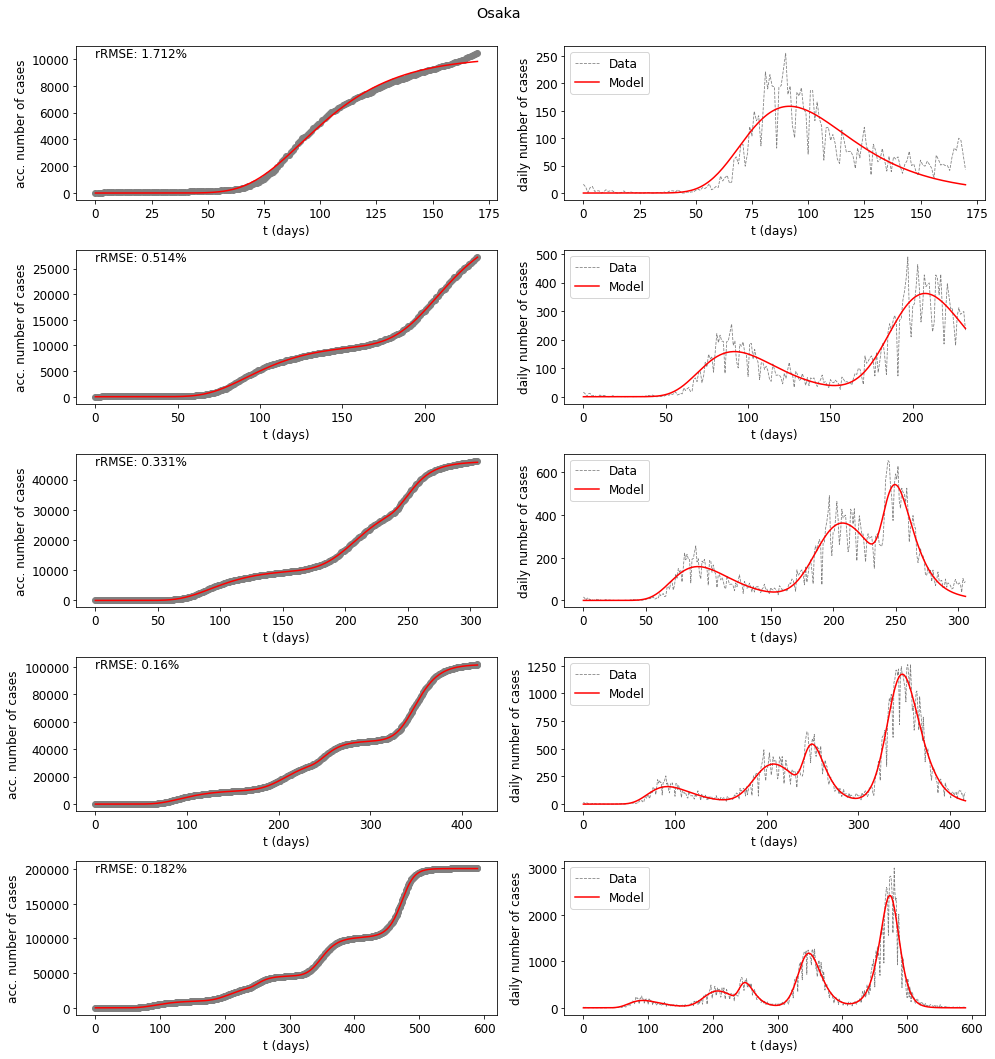

In [24]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # Moving average with 14-day window
    filtered_data = moving_average(data, 14)
    plt.plot(filtered_data, label="filtered (ma-14)")
    
    # 2nd Order Low-Pass Filter with 14-day window
    order = 2
    fs = len(data) # sampling rate       
    cutoff = 14 # cutoff freq.
    filtered_data =  butterworth_lowpass_filter(filtered_data, cutoff, fs, order)
    plt.plot(filtered_data, label="filtered (ma-14 + bw-low-pass)")

    # Median filter with 14-day window
    filtered_data = median_filter(filtered_data, 14)
    plt.plot(filtered_data, label="filtered (ma-14 + bw-low-pass + median-14)")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 25 days
    n_days_shift = 25
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"shifted signal ({n_days_shift} days)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 1'] = rel_rmse_list

### 2 - Só média móvel

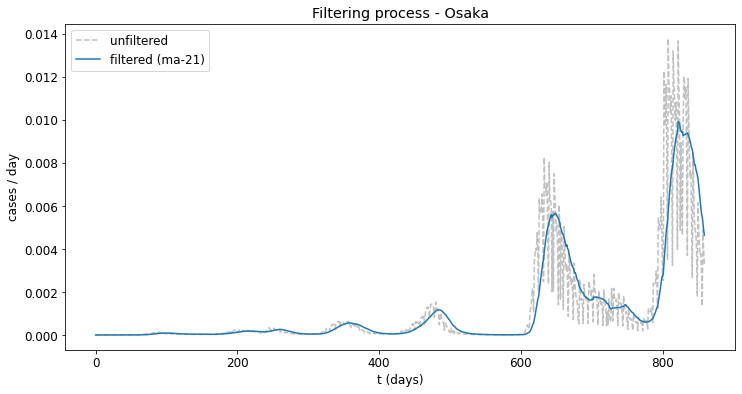

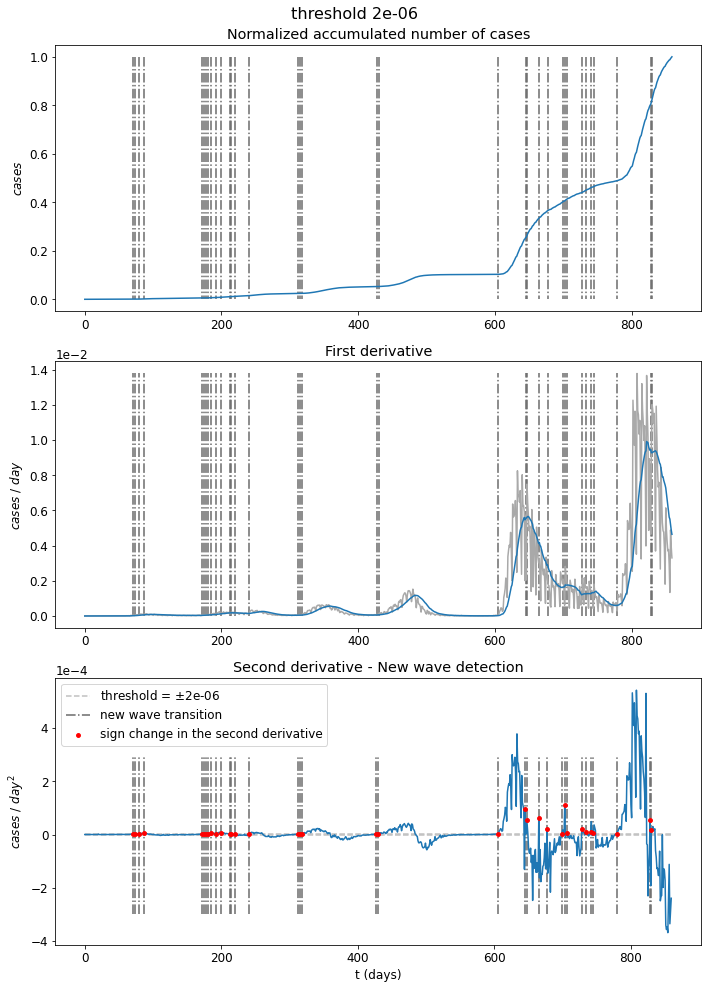

x_nw: [74, 80, 87, 171, 175]


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #1 - A0:171.5301379663221 | tp0:138.10314826210373 | delta0:13.763086707792034 | nu0:1.0 
(optimal) Sigmoid #1 - A0:171.5301379663221 | tp0:138.10314826210373 | delta0:13.763086707792034 | nu0:1.0 
Sigmoid #2 - A0:0.8576506898316104 | tp0:288.10314826210373 | delta0:13.763086707792034 | nu0:1.0 
(optimal) Sigmoid #2 - A0:0.8576506898316104 | tp0:288.10314826210373 | delta0:13.763086707792034 | nu0:1.0 
Sigmoid #3 - A0:0.0042882534491580524 | tp0:438.10314826210373 | delta0:13.763086707792034 | nu0:1.0 
(optimal) Sigmoid #3 - A0:0.0042882534491580524 | tp0:438.10314826210373 | delta0:13.763086707792034 | nu0:1.0 
Sigmoid #4 - A0:2.1441267245790263e-05 | tp0:588.1031482621038 | delta0:13.763086707792034 | nu0:1.0 
(optimal) Sigmoid #4 - A0:2.1441267245790263e-05 | tp0:588.1031482621038 | delta0:13.763086707792034 | nu0:1.0 
Sigmoid #5 - A0:1.0720633622895131e-07 | tp0:738.1031482621038 | delta0:13.763086707792034 | nu0:1.0 


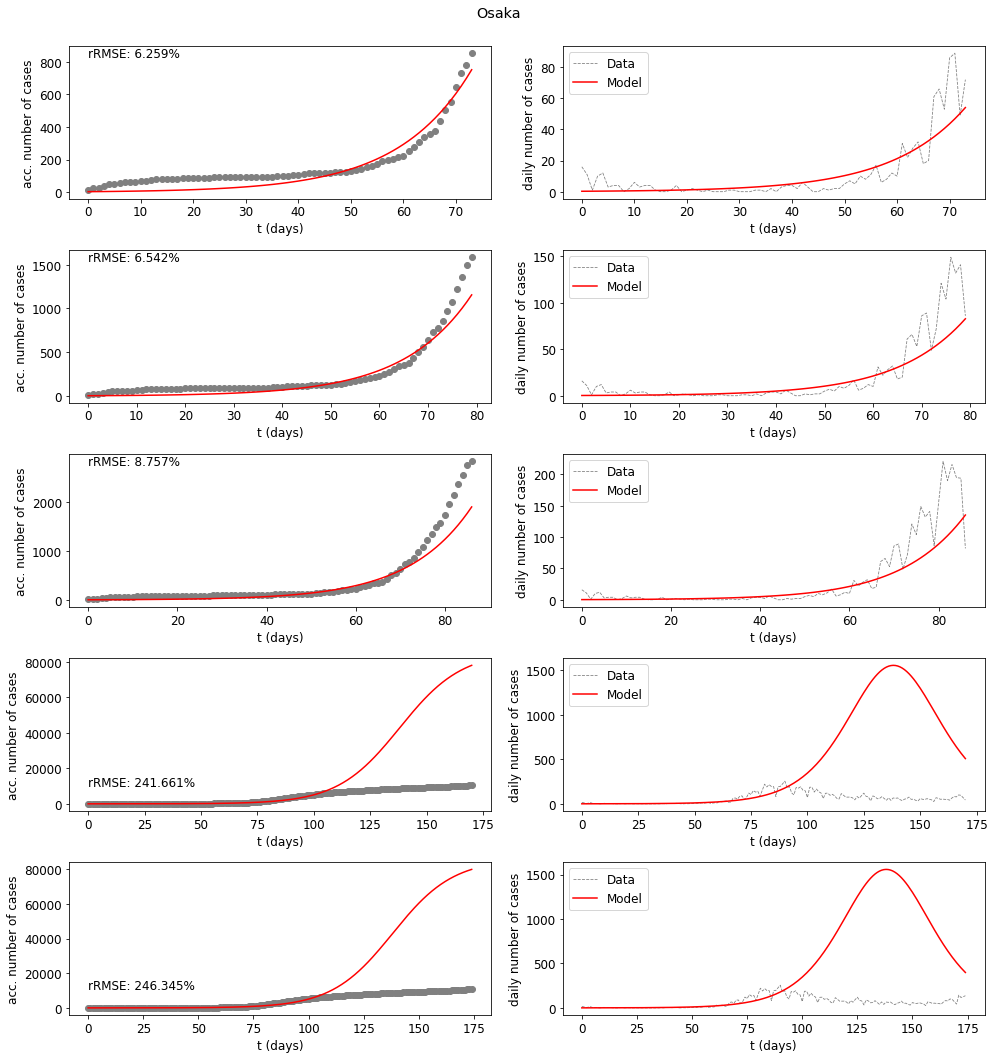

In [25]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # Moving average with 21-day window
    filtered_data = moving_average(data, 21)
    plt.plot(filtered_data, label="filtered (ma-21)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 2'] = rel_rmse_list

### 3 - Só filtro butterworth + avanço do sinal

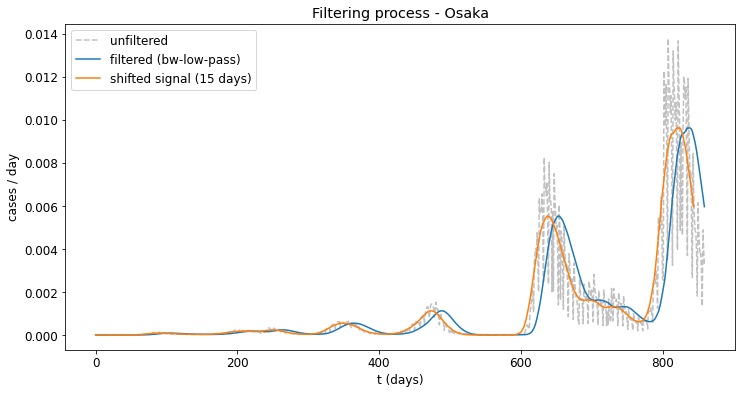

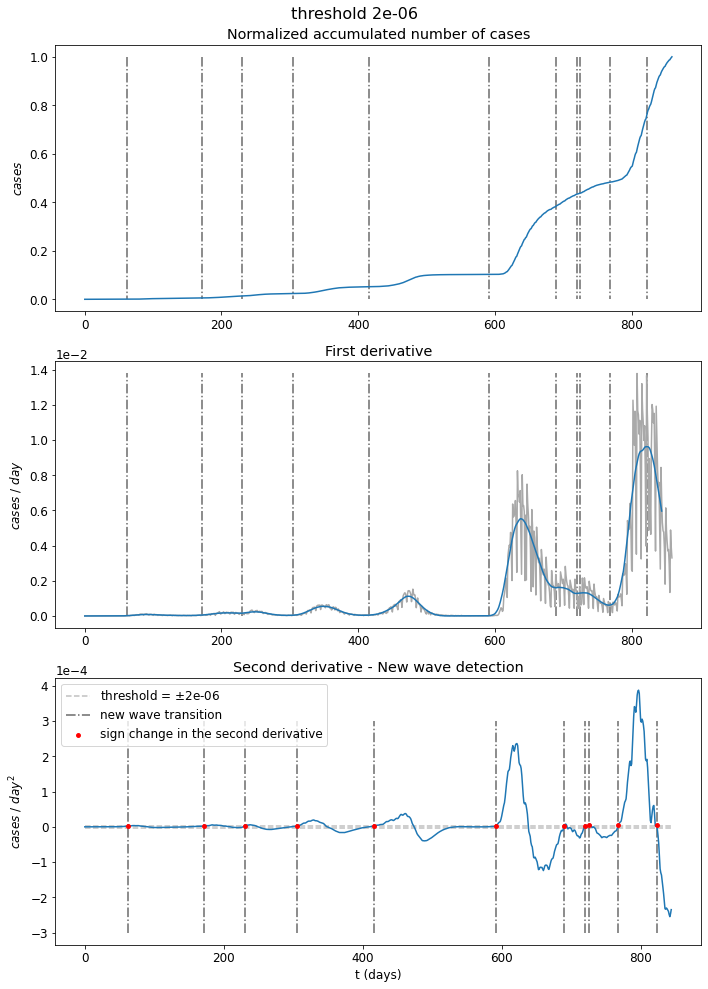

x_nw: [171, 230, 305, 416, 592]
Sigmoid #1 - A0:19.20972729900583 | tp0:99.56140716041266 | delta0:14.530072114851542 | nu0:1.0 
(optimal) Sigmoid #1 - A0:19.20972729900583 | tp0:99.56140716041266 | delta0:14.530072114851542 | nu0:1.0 
Sigmoid #2 - A0:36.63877280231475 | tp0:206.7270012678183 | delta0:11.770722468542974 | nu0:1.0 
(optimal) Sigmoid #2 - A0:36.63877280231475 | tp0:206.7270012678183 | delta0:11.770722468542974 | nu0:1.0 
Sigmoid #3 - A0:25.06981934898542 | tp0:255.14480443550374 | delta0:7.168143049761786 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #3 - A0:25.06981934898542 | tp0:255.14480443550374 | delta0:7.168143049761786 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #4 - A0:109.39854697582484 | tp0:350.9326691079182 | delta0:11.329662389604506 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #4 - A0:109.39854697582484 | tp0:350.9326691079182 | delta0:11.329662389604506 | nu0:1.0 
Sigmoid #5 - A0:198.8652091544884 | tp0:471.86313765492076 | delta0:10.491571558644285 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))


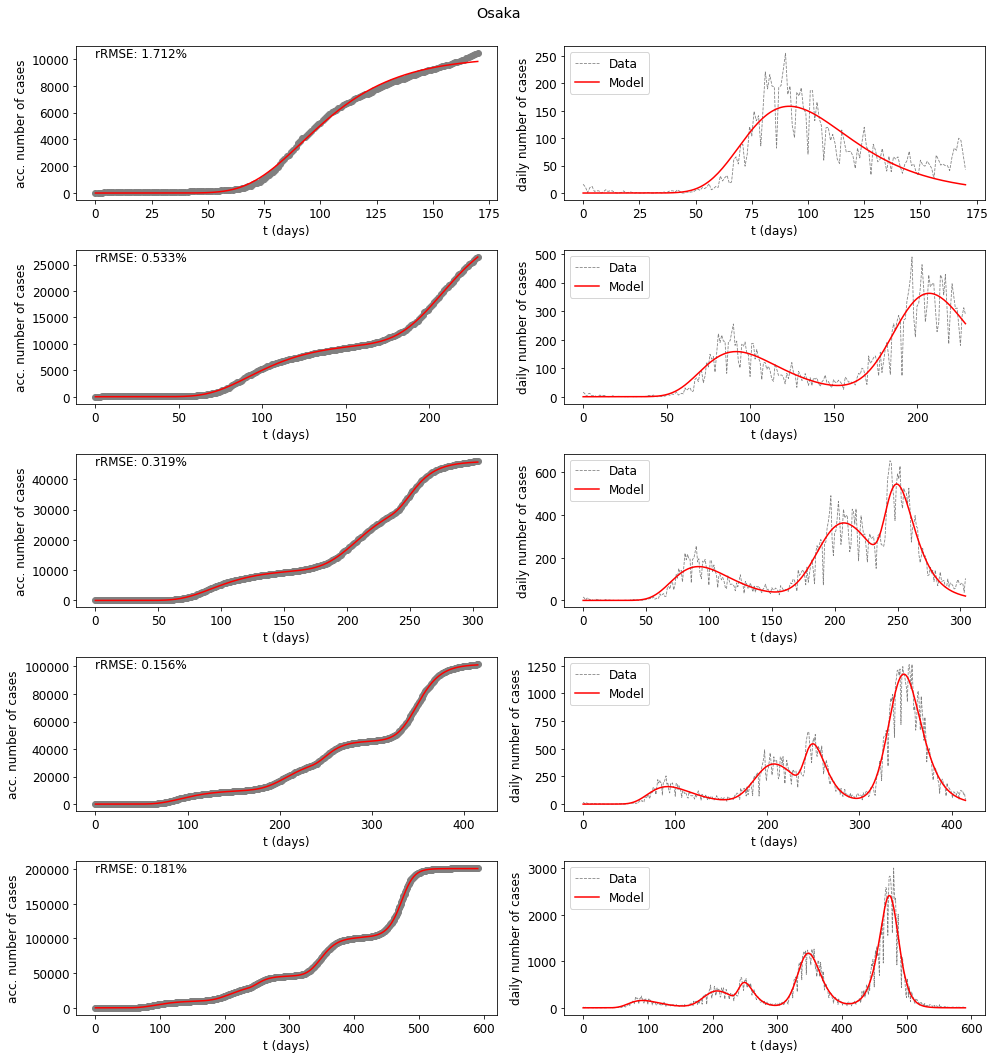

In [26]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # 2nd Order Low-Pass Filter with 14-day window
    order = 2
    fs = len(data) # sampling rate       
    cutoff = 14 # cutoff freq.
    filtered_data =  butterworth_lowpass_filter(data, cutoff, fs, order)
    plt.plot(filtered_data, label="filtered (bw-low-pass)")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 15 days
    n_days_shift = 15
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"shifted signal ({n_days_shift} days)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 3'] = rel_rmse_list

### 4 - Só mediana + avanço

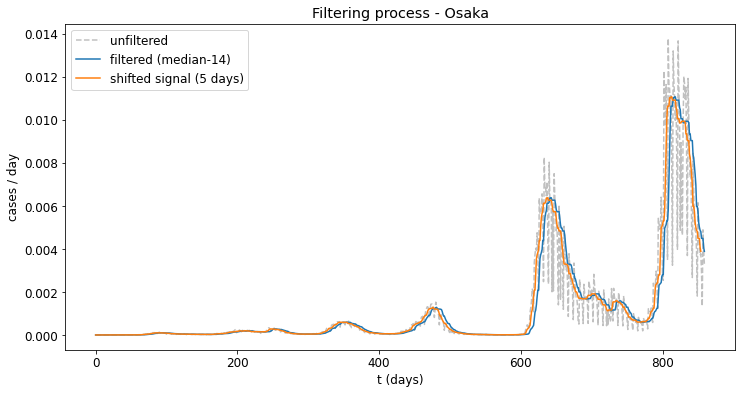

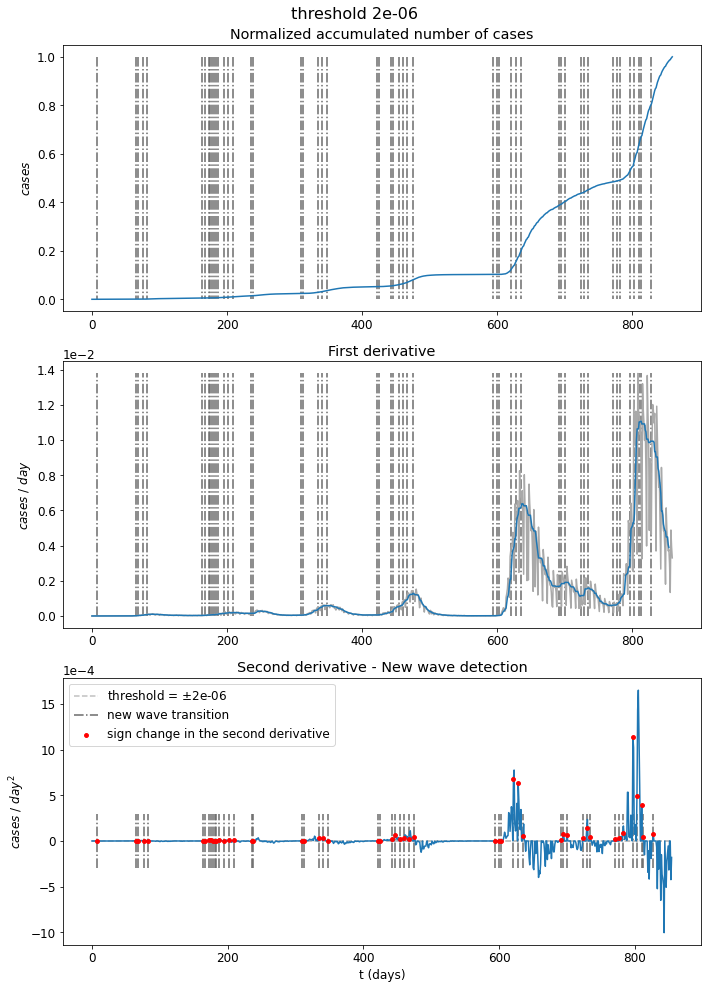

x_nw: [65, 68, 76, 82, 163]
Sigmoid #1 - A0:0.5808709124849046 | tp0:43.35598052268731 | delta0:16.254260279786738 | nu0:1.0 
(optimal) Sigmoid #1 - A0:0.5808709124849046 | tp0:43.35598052268731 | delta0:16.254260279786738 | nu0:1.0 
Sigmoid #2 - A0:0.0029043545624245232 | tp0:193.3559805226873 | delta0:16.254260279786738 | nu0:1.0 
(optimal) Sigmoid #2 - A0:0.0029043545624245232 | tp0:193.3559805226873 | delta0:16.254260279786738 | nu0:1.0 
Sigmoid #3 - A0:1.4521772812122617e-05 | tp0:343.35598052268733 | delta0:16.254260279786738 | nu0:1.0 
(optimal) Sigmoid #3 - A0:1.4521772812122617e-05 | tp0:343.35598052268733 | delta0:16.254260279786738 | nu0:1.0 
Sigmoid #4 - A0:7.260886406061309e-08 | tp0:493.35598052268733 | delta0:16.254260279786738 | nu0:1.0 
(optimal) Sigmoid #4 - A0:7.260886406061309e-08 | tp0:493.35598052268733 | delta0:16.254260279786738 | nu0:1.0 
Sigmoid #5 - A0:3.6304432030306546e-10 | tp0:643.3559805226873 | delta0:16.254260279786738 | nu0:1.0 


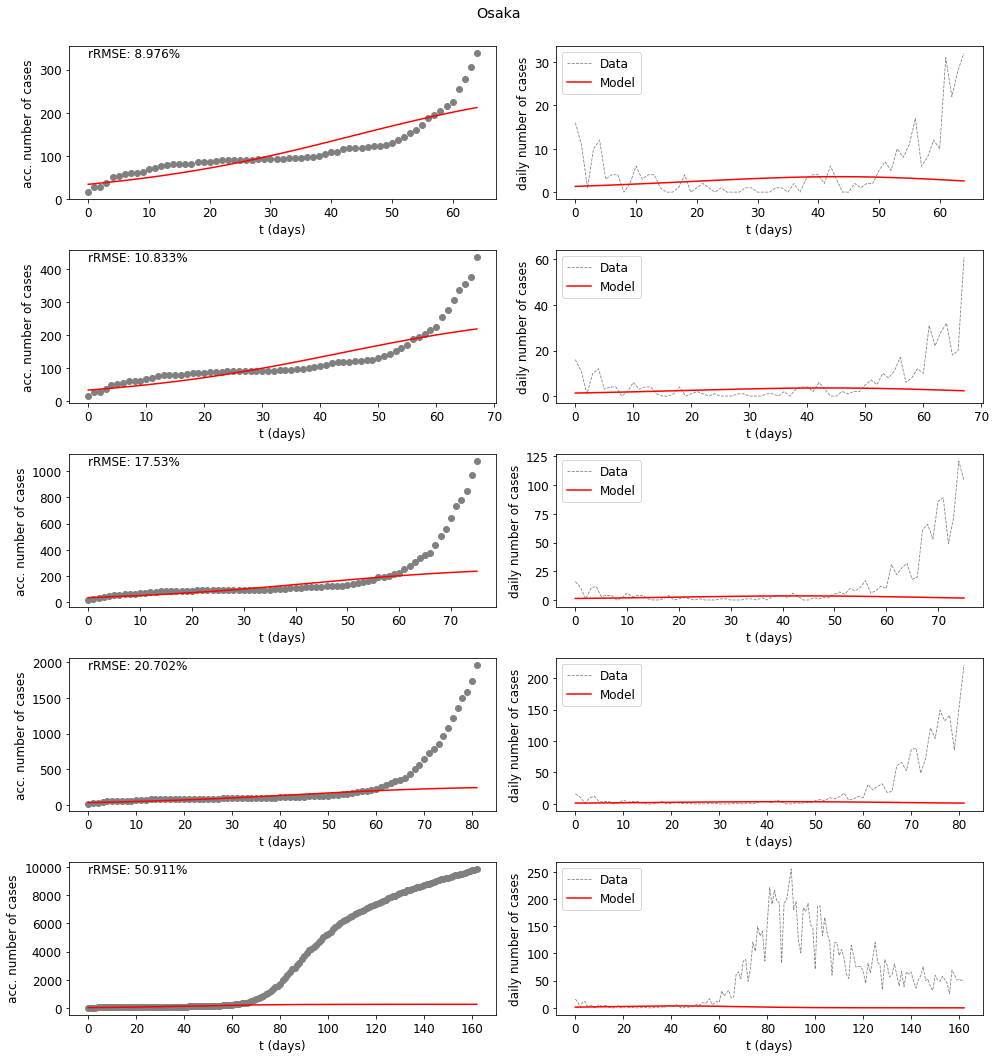

In [27]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # Median filter with 14-day window
    filtered_data = median_filter(data, 14)
    plt.plot(filtered_data, label="filtered (median-14)")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 5 days
    n_days_shift = 5
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"shifted signal ({n_days_shift} days)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 4'] = rel_rmse_list

### 5 - Média móvel + Mediana + avanço

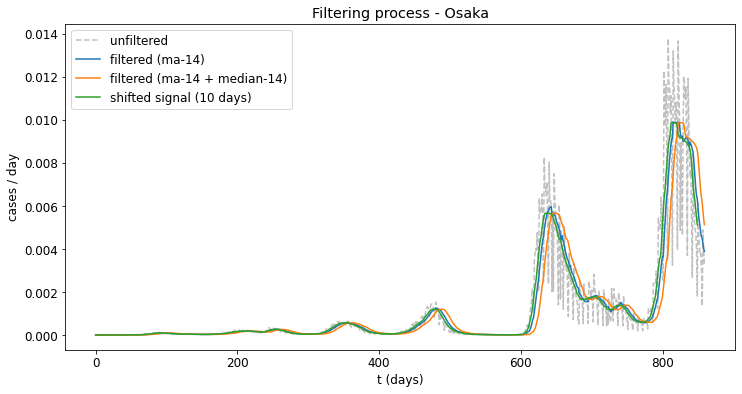

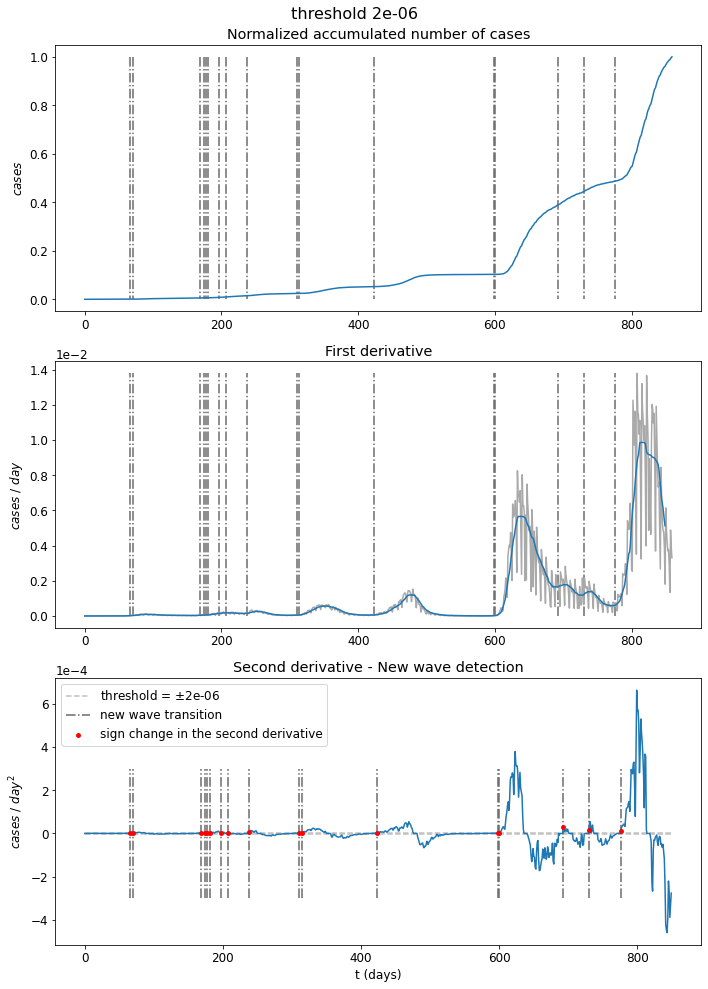

x_nw: [70, 168, 174, 177, 181]
Sigmoid #1 - A0:0.7529906698049189 | tp0:46.73419054613869 | delta0:17.504504949545346 | nu0:1.0 
(optimal) Sigmoid #1 - A0:0.7529906698049189 | tp0:46.73419054613869 | delta0:17.504504949545346 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/Organizado/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #2 - A0:18.0230751564414 | tp0:99.95052963945136 | delta0:13.243300773461643 | nu0:1.0 
(optimal) Sigmoid #2 - A0:18.0230751564414 | tp0:99.95052963945136 | delta0:13.243300773461643 | nu0:1.0 
Sigmoid #3 - A0:0.090115375782207 | tp0:249.95052963945136 | delta0:13.243300773461643 | nu0:1.0 
(optimal) Sigmoid #3 - A0:0.090115375782207 | tp0:249.95052963945136 | delta0:13.243300773461643 | nu0:1.0 
Sigmoid #4 - A0:0.00045057687891103505 | tp0:399.95052963945136 | delta0:13.243300773461643 | nu0:1.0 
(optimal) Sigmoid #4 - A0:0.00045057687891103505 | tp0:399.95052963945136 | delta0:13.243300773461643 | nu0:1.0 
Sigmoid #5 - A0:2.2528843945551755e-06 | tp0:549.9505296394514 | delta0:13.243300773461643 | nu0:1.0 


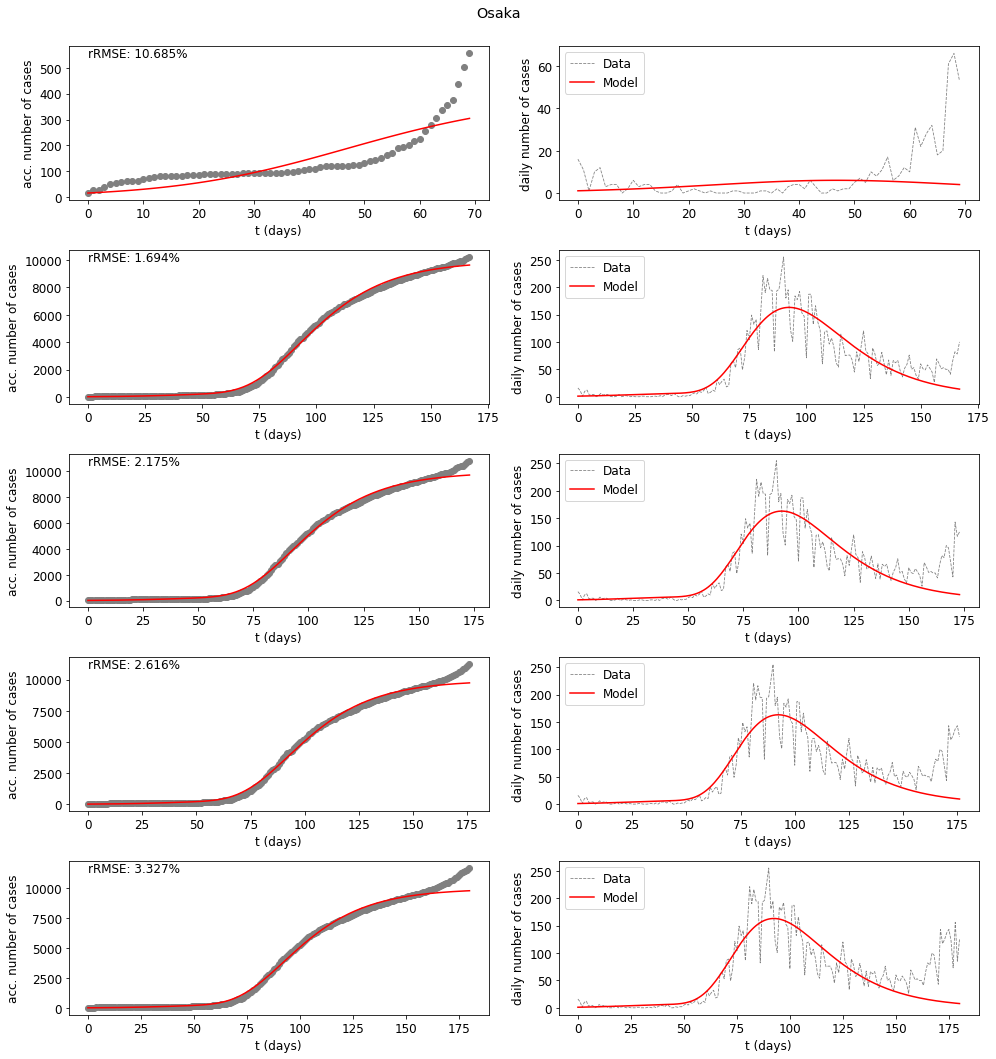

In [28]:
def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Filtering process - {city_name}")
    plt.xlabel("t (days)")
    plt.ylabel("cases / day")

    # Plotting unfiltered version
    plt.plot(data, label="unfiltered", c='silver', linestyle='dashed')

    # Moving average with 14-day window
    filtered_data = moving_average(data, 14)
    plt.plot(filtered_data, label="filtered (ma-14)")
    # Median filter with 14-day window
    filtered_data = median_filter(filtered_data, 14)
    plt.plot(filtered_data, label="filtered (ma-14 + median-14)")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 25 days
    n_days_shift = 10
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"shifted signal ({n_days_shift} days)")

    plt.legend()
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

# =================================================================================================

# Transition Points
x_nw = get_transition_points(acc_data, visual=True, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

sig_params, rel_rmse_list = optimize.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor
                            )

rel_rmse_by_test['Test 5'] = rel_rmse_list

### Bônus - Experimentando frequência de corte do Butterworth
Teste antigo que fiz, mas agora com dados do Japão

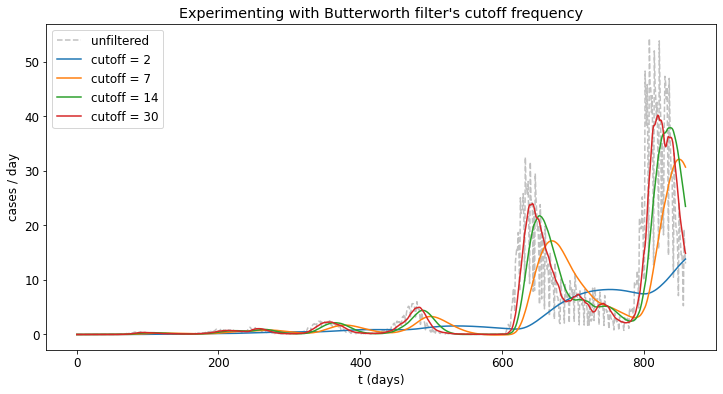

In [29]:
plt.figure(figsize=(12,6))
plt.title("Experimenting with Butterworth filter's cutoff frequency")
plt.xlabel("t (days)")
plt.ylabel("cases / day")

unf_daily_n_cases = daily_data

plt.plot(unf_daily_n_cases, label="unfiltered", c='silver', linestyle='dashed')

order = 2
fs = len(data) # sampling rate       

cutoff = 2 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 7 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 14 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

cutoff = 30 # cutoff freq.
filtered =  butterworth_lowpass_filter(unf_daily_n_cases, cutoff, fs, order)
plt.plot(filtered, label=f"cutoff = {cutoff}")

plt.legend()
plt.show()


### Resumo dos resultados

- Teste 1 - Filtragem padrão _(ma-14 + bw-low-pass + median-14 + shift-25)_

- Teste 2 - Apenas filtro de média móvel _(ma-21)_

- Teste 3 - Apenas filtro passa baixas Butterworth _(bw-low-pass + shift-15)_

- Teste 4 - Apenas filtro de mediana _(median-14 + shift-5)_
    
- Teste 5 - Média móvel + Mediana _(ma-14 + median-14 + shift-10)_

In [30]:
pd.DataFrame(rel_rmse_by_test)

,Interval,Test 1,Test 2,Test 3,Test 4,Test 5
0,Wave 1,1.712%,6.259%,1.712%,8.976%,10.685%
1,Waves 1 to 2,0.514%,6.542%,0.533%,10.833%,1.694%
2,Waves 1 to 3,0.331%,8.757%,0.319%,17.53%,2.175%
3,Waves 1 to 4,0.16%,241.661%,0.156%,20.702%,2.616%
4,Waves 1 to 5,0.182%,246.345%,0.181%,50.911%,3.327%


Teste 3, que aplica apenas o filtro Butterworth passa baixas, apresentou os menores valores de rRMSE.